In [2]:
%matplotlib inline
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('/home/ngrav/project')
from wearables.scripts import utils as wearutils

plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=1
plt.rcParams['savefig.dpi'] = 600
sns.set_style("ticks")

In [3]:
import importlib
importlib.reload(wearutils)

<module 'wearables.scripts.utils' from '/home/ngrav/project/wearables/scripts/utils.py'>

In [4]:
pfp = '/home/ngrav/project/wearables/results'
raw_md_fp = '/home/ngrav/data/wearables/raw/MOD_Data_2021.csv'
md = pd.read_csv(os.path.join(pfp, 'md_220912.csv'), index_col=0)
raw_md = pd.read_csv(raw_md_fp, low_memory=False)

# quick stats

In [29]:
from scipy.stats import spearmanr

# all

a = md.loc[:, 'KPAS'].to_numpy()
b = md.loc[:, 'PQSI'].to_numpy()

spearmanr(a, b)

SpearmanrResult(correlation=0.35735355833345595, pvalue=2.1989977252862716e-70)

In [30]:
# PTB+
a = md.loc[(md['Pre-term birth']), 'KPAS'].to_numpy()
b = md.loc[(md['Pre-term birth']), 'PQSI'].to_numpy()

spearmanr(a, b)

SpearmanrResult(correlation=0.3598253957342372, pvalue=6.851474417063248e-10)

In [31]:
# PTB-
a = md.loc[~(md['Pre-term birth']), 'KPAS'].to_numpy()
b = md.loc[~(md['Pre-term birth']), 'PQSI'].to_numpy()

spearmanr(a, b)

SpearmanrResult(correlation=0.3571876871079543, pvalue=4.443541003274149e-62)

In [6]:
raw_md.head()

,record_id,redcap_event_name,redcap_survey_identifier,customid,refused_future_research___1,refused_future_research___2,refused_future_research___3,reader,reader_text,age_enroll,...,edinb3_3trim,edinb4_3trim,edinb5_3trim,edinb6_3trim,edinb7_3trim,edinb8_3trim,edinb9_3trim,edinb10_3trim,edinburgh_check_trim3___1,third_edinburgh_depression_scale_complete
0,4,general_arm_1,NaN,4,0,0,0,7.0,Kristi,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,6,general_arm_1,NaN,6,0,0,0,4.0,NaN,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,9,general_arm_1,NaN,9,0,0,0,4.0,NaN,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,10,general_arm_1,NaN,10,0,0,0,4.0,NaN,29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,21,general_arm_1,NaN,21,0,0,0,4.0,NaN,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


# coding design 

for loop vs. lambda

## check missingness for multiple visits

In [7]:
def calc_agg_metrics(metadata, 
                     raw_md_fp='/home/ngrav/project/wearables/data/raw/MOD_Data_2021.csv',
                     verbose=False,):
    '''Compute edinburgh depression scale, sleep quality, and activity agg score
    
    Details:
      Metrics added include:
        - Pittsburgh Sleep Quality Index: sum it [REF](https://pubmed.ncbi.nlm.nih.gov/2748771/)
        - Kaiser Physical Activity: average in category, then sum 4 categories (can use weighted version for preg) [REF](doi: 10.1249/01.mss.0000181301.07516.d6)
        - Epworth Sleepiness scale: simple sum of 8 ques [Ref](https://epworthsleepinessscale.com/about-the-ess/)
        - Edinburgh depression [REF: Cox et al. Detection of postnatal depression: Development of the 10-item Edinburgh Postnatal Depression Scale. British Journal of Psychiatry 1987]
      Not calculated, but possibly could be: 
        - WHIRS/MCTQ/IRLS
        - Berlin Questionaire (Sleep Apnea High Risk): see Fig 1 in doi: 10.1097/WNO.0b013e31821a4d54
        
    Arguments:
      metadata (pd.DataFrame): md dataframe
      
    NOTE:
      - optimally, would assign visit num (1 through 3) for up to 6 measurements via closest
        date rather than first measurement through by carrying last one forward. 
    '''
    # load raw_md to grab that data
    raw_md_fp = '/home/ngrav/data/wearables/raw/MOD_Data_2021.csv'
    raw_md = pd.read_csv(raw_md_fp, low_memory=False)
    
    # calc scores
    w = [0.5, 0.2, 0.25, 0.05]  # preg adj: [0.5, 0.2, 0.25, 0.05] 
    ## PQSI
    for i in range(1, 3+1):
        # sleep quality
        comp1 = (raw_md['sleep_qual%s' % str(ii)] - 1).fillna(value=0.)
        minsleep = wearutils.tdiff_from24htime(raw_md['bedtime_%strim' % str(i)], raw_md['sleepact_%strim' % str(i)])
        scr = pd.Series(index=minsleep.index, dtype='float64')
        scr.loc[(minsleep <= 15)] = 0
        scr.loc[(minsleep < 30) & (minsleep >= 16)] = 1
        scr.loc[(minsleep >= 30) & (minsleep < 60)] = 2
        scr.loc[(minsleep >= 60)] = 3
        # sleep latency
        comp2 = scr + (raw_md['slp30_%strim' % i] - 1).fillna(value=0.)
        del minsleep, scr
        # sleep duration
        hsleep = wearutils.tdiff_from24htime(raw_md['sleepact_%strim' % str(i)], raw_md['wakeup4_%strim' % str(i)], minutes_not_h=False)
        comp3 = pd.Series(index=hsleep.index, dtype='float64')
        comp3.loc[(hsleep > 7)] = 0
        comp3.loc[(hsleep <= 7) & (hsleep > 6)] = 1
        comp3.loc[(hsleep <=6) & (hsleep > 5)] = 2
        comp3.loc[(hsleep <= 5)] = 3
        # sleep efficiency
        hbed = wearutils.tdiff_from24htime(raw_md['bedtime_%strim' % str(i)], raw_md['wakeup4_%strim' % str(i)], minutes_not_h=False)
        slp_eff = (hsleep / hbed)
        slp_eff = slp_eff.fillna(value=1.)
        comp4 = pd.Series(index=hsleep.index, dtype='float64')
        comp4.loc[(slp_eff > 0.85)] = 1
        comp4.loc[(slp_eff > 0.75) & (slp_eff <= 0.85)] = 2
        comp4.loc[(slp_eff > 0.65) & (slp_eff <= 0.75)] = 3
        comp4.loc[(slp_eff <= 0.65)] = 3
        del slp_eff
        # sleep disturbances 
        scr = (
            (raw_md['slpwake_%strim' % str(i)] - 1).fillna(value=0.) + (raw_md['slpbath_%strim' % str(i)] - 1).fillna(value=0.) + 
            (raw_md['slpbreathe_%strim' % str(i)] - 1).fillna(value=0.) + (raw_md['slpcough_%strim' % str(i)] - 1).fillna(value=0.) + 
            (raw_md['slpcold_%strim' % str(i)] - 1).fillna(value=0.) + (raw_md['slphot_%strim' % str(i)] - 1).fillna(value=0.) + 
            (raw_md['slpdream_%strim' % str(i)] - 1).fillna(value=0.) + (raw_md['slppain_%strim' % str(i)] - 1).fillna(value=0.) + 
            (raw_md['slptwitch_%strim' % str(i)] - 1).fillna(value=0.) + (raw_md['slpother_num%s' % str(i)] - 1).fillna(value=0.) 
        )
        comp5 = pd.Series(index=scr.index, dtype='float64')
        comp5.loc[(scr == 0)] = 0
        comp5.loc[(scr > 0) & (scr < 10)] = 1
        comp5.loc[(scr >= 10) & (scr < 19)] = 2
        comp5.loc[(scr >= 19)] = 3
        del scr
        # sleep medicaftion
        comp6 = (raw_md['slpmed%s' % str(i)] - 1).fillna(value=0.)
        # daytime dysfunction
        scr = (raw_md['slpdrive%s' % str(i)] - 1).fillna(value=0.) + (raw_md['slpenergy%s' % str(i)] - 1).fillna(value=0.)
        comp7 = pd.Series(index=scr.index, dtype='float64')
        comp7.loc[(scr == 0)] = 0
        comp7.loc[(scr > 0) & (scr <= 2)] = 1
        comp7.loc[(scr > 2) & (scr <= 4)] = 2
        comp7.loc[(scr > 4)] = 3   
        del scr
        raw_md['PQSI_%s' % str(i)] = comp1 + comp2 + comp3 + comp4 + comp5 + comp6 + comp7
        
        ## KPAS
        N = 11
        rescale1 = raw_md['under2care%s' % i].fillna(value=1.)
        rescale1 = (5-1)*((rescale1 - rescale1.min())/(rescale1.max() - rescale1.min())) + 1
        rescale2 = raw_md['caretoddler%s' % i].fillna(value=1.)
        rescale2 = (5-1)*((rescale2 - rescale2.min())/(rescale2.max() - rescale2.min())) + 1
        rescale3 = raw_md['caredisabled%s' % i].fillna(value=1.)
        rescale3 = (5-1)*((rescale3 - rescale3.min())/(rescale3.max() - rescale3.min())) + 1
        comp1 = (rescale1 + rescale2 + rescale3 + 
                 raw_md['mealprepday%s' % i].fillna(value=1.) +
                 raw_md['mealprepwkend%s' % i].fillna(value=1.) + raw_md['majorclean%s' % i].fillna(value=1.) + 
                 raw_md['routineclean%s' % i].fillna(value=1.) + raw_md['grocery%s' % i].fillna(value=1.) +
                 raw_md['yardwork%s' % i].fillna(value=1.) + raw_md['heavyoutdoor%s' % i].fillna(value=1.) +
                 raw_md['homedecor%s' % i].fillna(value=1.)) / N
        # occupational activities 
        N = 7
        comp2 = (raw_md['workload_weight%s' % i].fillna(value=1.) + (raw_md['after_work%s' % i].fillna(value=0.) + 1) +
                 (5 - raw_md['job_sit%s' % i].fillna(value=0.) + 1) + (raw_md['job_stand%s' % i].fillna(value=0.) + 1) + 
                 (raw_md['job_walk%s' % i].fillna(value=0.) + 1) + (raw_md['job_lift%s' % i].fillna(value=0.) + 1) +
                 (raw_md['job_sweat%s' % i].fillna(value=0.) + 1)) / N
        # active living
        N = 4
        comp3 = (raw_md['workwalk%s' % i].fillna(value=1.) + (5-raw_md['television_watch%s' % i].fillna(value=5.) + 1) +
                 raw_md['walk15min%s' % i].fillna(value=1.) + raw_md['bike15min%s' % i].fillna(value=1.)) / N

        # sports/exercise index
        rescale1 = raw_md['intensity%s' % i].fillna(value=1.).replace(4, 1)
        rescale1 = (5-1)*((rescale1 - rescale1.min())/(rescale1.max() - rescale1.min())) + 1
        suba = raw_md['activities%s' % i].fillna(value=0)*((rescale1 + 
                                                            raw_md['activity_month%s' % i].fillna(value=1.).replace(6, 1) + 
                                                            raw_md['activity_hours%s' % i].fillna(value=1.).replace(6, 1))/3)
        del rescale1
        rescale1 = raw_md['intensityb%s' % i].fillna(value=1.).replace(4, 1)
        rescale1 = (5-1)*((rescale1 - rescale1.min())/(rescale1.max() - rescale1.min())) + 1
        subb = raw_md['activityb%s' % i].fillna(value=0)*((rescale1 + 
                                                           raw_md['activityb_month%s' % i].fillna(value=1.).replace(6, 1) + 
                                                           raw_md['activityb_hours%s' % i].fillna(value=1.).replace(6, 1))/3)
        del rescale1
        rescale1 = raw_md['intensityc%s' % i].fillna(value=1.).replace(4, 1)
        rescale1 = (5-1)*((rescale1 - rescale1.min())/(rescale1.max() - rescale1.min())) + 1
        subc = raw_md['activityc%s' % i].fillna(value=0)*((rescale1 + 
                                                           raw_md['activityc_month%s' % i].fillna(value=1.).replace(6, 1) + 
                                                           raw_md['activityc_hours%s' % i].fillna(value=1.).replace(6, 1))/3)
        del rescale1
        N = pd.Series(3, index=raw_md.index)
        N.loc[suba > 0] += 1
        N.loc[subb > 0] += 1
        N.loc[subc > 0] += 1
        comp4 = (raw_md['recreational_act%s' % i].fillna(value=1.) + raw_md['playsports%s' % i].fillna(value=1.) +
                 raw_md['sports_sweat%s' % i].fillna(value=1.).replace(6, 1) + 
                 suba + subb + subc) / N

        raw_md['KPAS_%s' % str(i)] = 4*(w[0]*comp1 + w[1]*comp2 + w[2]*comp3 + w[3]*comp4)
            
        ## Epworth
        raw_md['EpworthSS_%s' % i] = (
            raw_md['sitting%s' % i].fillna(value=0).replace(4, 0) + 
            raw_md['tv%s' % i].fillna(value=0).replace(4, 0) + 
            raw_md['inactive%s' % i].fillna(value=0).replace(4, 0) + 
            raw_md['passenger%s' % i].fillna(value=0).replace(4, 0) + 
            raw_md['reset%s' % i].fillna(value=0).replace(4, 0) + 
            raw_md['talking%s' % i].fillna(value=0).replace(4, 0) + 
            raw_md['afterlunch%s' % i].fillna(value=0).replace(4, 0) + 
            raw_md['cartraffic%s' % i].fillna(value=0).replace(4, 0)
        )
        
        ## Edinburgh
        raw_md['Edinburgh_%s' % i] = (
            raw_md['edinb1_%strim' % i].fillna(value=1) - 1 + 
            raw_md['edinb2_%strim' % i].fillna(value=1) - 1 + 
            raw_md['edinb3_%strim' % i].fillna(value=1) - 1 + 
            raw_md['edinb4_%strim' % i].fillna(value=1) - 1 + 
            raw_md['edinb5_%strim' % i].fillna(value=1) - 1 + 
            raw_md['edinb6_%strim' % i].fillna(value=1) - 1 + 
            raw_md['edinb7_%strim' % i].fillna(value=1) - 1 + 
            raw_md['edinb8_%strim' % i].fillna(value=1) - 1 + 
            raw_md['edinb9_%strim' % i].fillna(value=1) - 1 + 
            raw_md['edinb10_%strim' % i].fillna(value=1) - 1
        )
        
    # integrate
    metadata['visit_num'] = 1
    for pid in metadata['record_id']:
        if verbose:
            n_measurements = []
        unique_idxs = np.array([i for i in metadata['unique_id'] if i.split('_')[0] == str(pid)])
        unique_idxs = list(unique_idxs[np.argsort([float(i.split('_')[-1]) for i in unique_idxs])])
        if verbose:
            n_measruements.append(len(unique_idxs)) # max ~ 6 but columns only go up to 3
        for i, idx in enumerate(unique_idxs):
            if i == 1:
                metadata.loc[idx, 'visit_num'] = 2
            elif i >= 2:
                metadata.loc[idx, 'visit_num'] = 3
                
    
    for i in range(1, 4):
        if i==1:
            mdprime = metadata.loc[metadata['visit_num']==i].merge(
                raw_md.loc[:, ['PQSI_%s' % i,
                               'KPAS_%s' % i,
                               'EpworthSS_%s' % i,
                               'Edinburgh_%s' % i,
                               'record_id']], 
                left_on='record_id', right_on='record_id', 
                how='left')
            mdprime = mdprime.rename(columns={'PQSI_%s' % i: 'PQSI',
                                    'KPAS_%s' % i: 'KPAS',
                                    'EpworthSS_%s' % i: 'EpworthSS',
                                    'Edinburgh_%s' % i: 'Edinburgh',})
        else:
            dt = metadata.loc[metadata['visit_num']==i].merge(
                raw_md.loc[:, ['PQSI_%s' % i,
                               'KPAS_%s' % i,
                               'EpworthSS_%s' % i,
                               'Edinburgh_%s' % i,
                               'record_id']], 
                left_on='record_id', right_on='record_id', 
                how='left')
            dt = dt.rename(columns={'PQSI_%s' % i: 'PQSI',
                                    'KPAS_%s' % i: 'KPAS',
                                    'EpworthSS_%s' % i: 'EpworthSS',
                                    'Edinburgh_%s' % i: 'Edinburgh',})
            mdprime = mdprime.append(dt)
    mdprime = mdprime.set_index('unique_id')
    return mdprime

    

In [9]:
# mdprime = calc_agg_metrics(md)
# mdprime.head()
mdprime = md
mdprime.shape

(2305, 131)

In [10]:
mdprime.shape

(2305, 131)

In [15]:
md = md.reset_index()

# dev

## integrate into metadata

In [20]:
verbose = True

In [21]:
md['visit_num'] = 1
for pid in md['record_id']:
    if verbose:
        n_measurements = []
    unique_idxs = np.array([i for i in md['unique_id'] if i.split('_')[0] == str(pid)])
    unique_idxs = list(unique_idxs[np.argsort([float(i.split('_')[-1]) for i in unique_idxs])])
    if verbose:
        n_measruements.append(len(unique_idxs)) # max ~ 6 but columns only go up to 3
    for i, idx in enumerate(unique_idxs):
        if i == 1:
            md.loc[idx, 'visit_num'] = 2
        elif i >= 2:
            md.loc[idx, 'visit_num'] = 3
    
        

NameError: name 'n_measruements' is not defined

In [158]:
md.head()

,record_id,age_enroll,marital,gestage_by,insur,ethnicity,race,bmi_1vis,prior_ptb_all,fullterm_births,...,IVm,min_rest,ave_logpseudocount_wake,ave_logpseudocount_sleep,ave_logpseudocount_wknd,ave_logpseudocount_wkday,ave_logpseudocount_day,ave_logpseudocount_night,Pre-term birth,visit_num
1024_10,1024,23.0,0.0,0.0,5.0,0.0,1.0,21.378954,0.0,1.0,...,0.281756,7954.0,5.454885,0.151541,2.633760,0.724612,1.945987,0.594180,False,1
2180_35,2180,34.0,1.0,1.0,3.0,0.0,0.0,31.732640,0.0,0.0,...,0.574621,5751.0,5.124668,0.826768,2.613515,2.696182,2.933929,2.411196,False,3
2180_12,2180,34.0,1.0,1.0,3.0,0.0,0.0,31.732640,0.0,0.0,...,1.822176,10075.0,5.165496,0.001474,0.000000,0.005650,0.008072,0.000000,False,1
2180_26,2180,34.0,1.0,1.0,3.0,0.0,0.0,31.732640,0.0,0.0,...,0.549746,5863.0,5.202776,0.819541,2.526396,2.704035,3.215078,2.091485,False,2
2148_34,2148,34.0,1.0,2.0,3.0,0.0,0.0,22.406605,0.0,1.0,...,0.284855,5069.0,5.325096,0.606202,2.915334,2.966768,4.487991,1.416154,False,3


In [162]:
mdprime = md.loc[md['visit_num']==1].merge(raw_md.loc[:, ['PQSI_1', 'record_id']], left_on='record_id', right_on='record_id', how='left')

In [164]:
mdprime.rename(columns={'PQSI_1': 'PQSI'})

,record_id,age_enroll,marital,gestage_by,insur,ethnicity,race,bmi_1vis,prior_ptb_all,fullterm_births,...,min_rest,ave_logpseudocount_wake,ave_logpseudocount_sleep,ave_logpseudocount_wknd,ave_logpseudocount_wkday,ave_logpseudocount_day,ave_logpseudocount_night,Pre-term birth,visit_num,PQSI
0,1024,23.0,0.0,0.0,5.0,0.0,1.0,21.378954,0.0,1.0,...,7954.0,5.454885,0.151541,2.633760,0.724612,1.945987,0.594180,False,1,4.0
1,2180,34.0,1.0,1.0,3.0,0.0,0.0,31.732640,0.0,0.0,...,10075.0,5.165496,0.001474,0.000000,0.005650,0.008072,0.000000,False,1,10.0
2,2148,34.0,1.0,2.0,3.0,0.0,0.0,22.406605,0.0,1.0,...,4846.0,5.382191,0.621268,2.740293,3.234584,4.675870,1.510846,False,1,11.0
3,1062,31.0,0.0,1.0,5.0,0.0,1.0,40.106270,0.0,0.0,...,7613.0,5.172205,0.293814,2.453821,1.101337,2.126169,0.849354,False,1,8.0
4,1306,25.0,0.0,3.0,5.0,0.0,1.0,24.555670,0.0,0.0,...,9365.0,4.902439,0.112690,0.385998,0.479015,0.724577,0.180301,False,1,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,2277,29.0,0.0,3.0,3.0,0.0,0.0,26.857763,1.0,0.0,...,4703.0,5.440273,0.476186,3.431643,3.001211,4.046417,2.201966,False,1,13.0
1226,1478,21.0,0.0,4.0,1.0,0.0,1.0,41.400460,0.0,0.0,...,8583.0,5.649409,0.107236,0.208221,1.219152,1.261382,0.599247,False,1,10.0
1227,2425,28.0,1.0,2.0,3.0,0.0,0.0,29.617516,0.0,1.0,...,5658.0,5.156258,0.617804,2.018655,2.844831,3.650448,1.567113,False,1,11.0
1228,1476,22.0,0.0,2.0,3.0,0.0,1.0,25.291360,0.0,1.0,...,5217.0,5.120161,0.832528,2.656305,2.998956,3.301950,2.500161,False,1,16.0


## PQSI

In [22]:
# PQSI
for i in range(1, 3+1):
    # sleep quality
    comp1 = (raw_md['sleep_qual%s' % str(ii)] - 1).fillna(value=0.)
    minsleep = wearutils.tdiff_from24htime(raw_md['bedtime_%strim' % str(i)], raw_md['sleepact_%strim' % str(i)])
    scr = pd.Series(index=minsleep.index, dtype='float64')
    scr.loc[(minsleep <= 15)] = 0
    scr.loc[(minsleep < 30) & (minsleep >= 16)] = 1
    scr.loc[(minsleep >= 30) & (minsleep < 60)] = 2
    scr.loc[(minsleep >= 60)] = 3
    # sleep latency
    comp2 = scr + (raw_md['slp30_%strim' % i] - 1).fillna(value=0.)
    del minsleep, scr
    # sleep duration
    hsleep = wearutils.tdiff_from24htime(raw_md['sleepact_%strim' % str(i)], raw_md['wakeup4_%strim' % str(i)], minutes_not_h=False)
    comp3 = pd.Series(index=hsleep.index, dtype='float64')
    comp3.loc[(hsleep > 7)] = 0
    comp3.loc[(hsleep <= 7) & (hsleep > 6)] = 1
    comp3.loc[(hsleep <=6) & (hsleep > 5)] = 2
    comp3.loc[(hsleep <= 5)] = 3
    # sleep efficiency
    hbed = wearutils.tdiff_from24htime(raw_md['bedtime_%strim' % str(i)], raw_md['wakeup4_%strim' % str(i)], minutes_not_h=False)
    slp_eff = (hsleep / hbed)
    slp_eff = slp_eff.fillna(value=1.)
    comp4 = pd.Series(index=hsleep.index, dtype='float64')
    comp4.loc[(slp_eff > 0.85)] = 1
    comp4.loc[(slp_eff > 0.75) & (slp_eff <= 0.85)] = 2
    comp4.loc[(slp_eff > 0.65) & (slp_eff <= 0.75)] = 3
    comp4.loc[(slp_eff <= 0.65)] = 3
    del slp_eff
    # sleep disturbances 
    scr = (
        (raw_md['slpwake_%strim' % str(i)] - 1).fillna(value=0.) + (raw_md['slpbath_%strim' % str(i)] - 1).fillna(value=0.) + 
        (raw_md['slpbreathe_%strim' % str(i)] - 1).fillna(value=0.) + (raw_md['slpcough_%strim' % str(i)] - 1).fillna(value=0.) + 
        (raw_md['slpcold_%strim' % str(i)] - 1).fillna(value=0.) + (raw_md['slphot_%strim' % str(i)] - 1).fillna(value=0.) + 
        (raw_md['slpdream_%strim' % str(i)] - 1).fillna(value=0.) + (raw_md['slppain_%strim' % str(i)] - 1).fillna(value=0.) + 
        (raw_md['slptwitch_%strim' % str(i)] - 1).fillna(value=0.) + (raw_md['slpother_num%s' % str(i)] - 1).fillna(value=0.) 
    )
    comp5 = pd.Series(index=scr.index, dtype='float64')
    comp5.loc[(scr == 0)] = 0
    comp5.loc[(scr > 0) & (scr < 10)] = 1
    comp5.loc[(scr >= 10) & (scr < 19)] = 2
    comp5.loc[(scr >= 19)] = 3
    del scr
    # sleep medicaftion
    comp6 = (raw_md['slpmed%s' % str(i)] - 1).fillna(value=0.)
    # daytime dysfunction
    scr = (raw_md['slpdrive%s' % str(i)] - 1).fillna(value=0.) + (raw_md['slpenergy%s' % str(i)] - 1).fillna(value=0.)
    comp7 = pd.Series(index=scr.index, dtype='float64')
    comp7.loc[(scr == 0)] = 0
    comp7.loc[(scr > 0) & (scr <= 2)] = 1
    comp7.loc[(scr > 2) & (scr <= 4)] = 2
    comp7.loc[(scr > 4)] = 3   
    del scr
    raw_md['PQSI_%s' % str(i)] = comp1 + comp2 + comp3 + comp4 + comp5 + comp6 + comp7
    

NameError: name 'ii' is not defined

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figur

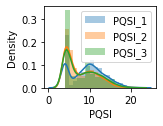

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(2, 1.5))
for i in range(1, 4):
    sns.distplot(raw_md['PQSI_%s' % i], ax=ax, label='PQSI_%s' % i)
    ax.set_xlabel('PQSI')
ax.legend()



## Kaiser physical activity

In [108]:
[i for i in raw_md.columns if 'recreation' in i]

['recreational_act1', 'recreational_act2', 'recreational_act3']

In [114]:
# fix N and rescaling 
N = pd.Series(3, index=raw_md.index)

In [140]:
# KPAS
w = [0.5, 0.2, 0.25, 0.05]  # preg adj: [0.5, 0.2, 0.25, 0.05] 
for i in range(1, 3+1):
    # household/caregiving
    N = 11
    rescale1 = raw_md['under2care%s' % i].fillna(value=1.)
    rescale1 = (5-1)*((rescale1 - rescale1.min())/(rescale1.max() - rescale1.min())) + 1
    rescale2 = raw_md['caretoddler%s' % i].fillna(value=1.)
    rescale2 = (5-1)*((rescale2 - rescale2.min())/(rescale2.max() - rescale2.min())) + 1
    rescale3 = raw_md['caredisabled%s' % i].fillna(value=1.)
    rescale3 = (5-1)*((rescale3 - rescale3.min())/(rescale3.max() - rescale3.min())) + 1
    comp1 = (rescale1 + rescale2 + rescale3 + 
             raw_md['mealprepday%s' % i].fillna(value=1.) +
             raw_md['mealprepwkend%s' % i].fillna(value=1.) + raw_md['majorclean%s' % i].fillna(value=1.) + 
             raw_md['routineclean%s' % i].fillna(value=1.) + raw_md['grocery%s' % i].fillna(value=1.) +
             raw_md['yardwork%s' % i].fillna(value=1.) + raw_md['heavyoutdoor%s' % i].fillna(value=1.) +
             raw_md['homedecor%s' % i].fillna(value=1.)) / N
    # occupational activities 
    N = 7
    comp2 = (raw_md['workload_weight%s' % i].fillna(value=1.) + (raw_md['after_work%s' % i].fillna(value=0.) + 1) +
             (5 - raw_md['job_sit%s' % i].fillna(value=0.) + 1) + (raw_md['job_stand%s' % i].fillna(value=0.) + 1) + 
             (raw_md['job_walk%s' % i].fillna(value=0.) + 1) + (raw_md['job_lift%s' % i].fillna(value=0.) + 1) +
             (raw_md['job_sweat%s' % i].fillna(value=0.) + 1)) / N
    # active living
    N = 4
    comp3 = (raw_md['workwalk%s' % i].fillna(value=1.) + (5-raw_md['television_watch%s' % i].fillna(value=5.) + 1) +
             raw_md['walk15min%s' % i].fillna(value=1.) + raw_md['bike15min%s' % i].fillna(value=1.)) / N
    
    # sports/exercise index
    rescale1 = raw_md['intensity%s' % i].fillna(value=1.).replace(4, 1)
    rescale1 = (5-1)*((rescale1 - rescale1.min())/(rescale1.max() - rescale1.min())) + 1
    suba = raw_md['activities%s' % i].fillna(value=0)*((rescale1 + 
                                                        raw_md['activity_month%s' % i].fillna(value=1.).replace(6, 1) + 
                                                        raw_md['activity_hours%s' % i].fillna(value=1.).replace(6, 1))/3)
    del rescale1
    rescale1 = raw_md['intensityb%s' % i].fillna(value=1.).replace(4, 1)
    rescale1 = (5-1)*((rescale1 - rescale1.min())/(rescale1.max() - rescale1.min())) + 1
    subb = raw_md['activityb%s' % i].fillna(value=0)*((rescale1 + 
                                                       raw_md['activityb_month%s' % i].fillna(value=1.).replace(6, 1) + 
                                                       raw_md['activityb_hours%s' % i].fillna(value=1.).replace(6, 1))/3)
    del rescale1
    rescale1 = raw_md['intensityc%s' % i].fillna(value=1.).replace(4, 1)
    rescale1 = (5-1)*((rescale1 - rescale1.min())/(rescale1.max() - rescale1.min())) + 1
    subc = raw_md['activityc%s' % i].fillna(value=0)*((rescale1 + 
                                                       raw_md['activityc_month%s' % i].fillna(value=1.).replace(6, 1) + 
                                                       raw_md['activityc_hours%s' % i].fillna(value=1.).replace(6, 1))/3)
    del rescale1
    N = pd.Series(3, index=raw_md.index)
    N.loc[suba > 0] += 1
    N.loc[subb > 0] += 1
    N.loc[subc > 0] += 1
    comp4 = (raw_md['recreational_act%s' % i].fillna(value=1.) + raw_md['playsports%s' % i].fillna(value=1.) +
             raw_md['sports_sweat%s' % i].fillna(value=1.).replace(6, 1) + 
             suba + subb + subc) / N
    
    raw_md['KPAS_%s' % str(i)] = 4*(w[0]*comp1 + w[1]*comp2 + w[2]*comp3 + w[3]*comp4)
    

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figur

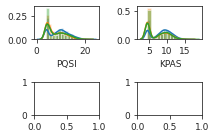

In [141]:
fig, ax = plt.subplots(2, 2, figsize=(3, 2))
for i in range(1, 4):
    sns.distplot(raw_md['PQSI_%s' % i], ax=ax[0, 0], label='%s' % i)
    ax[0, 0].set_xlabel('PQSI')
    ax[0, 0].set_ylabel('')
# ax.legend()
for i in range(1, 4):
    sns.distplot(raw_md['KPAS_%s' % i], ax=ax[0, 1], label='%s' % i)
    ax[0, 1].set_xlabel('KPAS')
    ax[0, 1].set_ylabel('')
    
fig.tight_layout()




In [142]:
for i, c in enumerate([comp1, comp2, comp3, comp4]):
    print(i+1, c.mean(), c.min(), c.max())

1 1.6328032281034892 1.0 5.0
2 2.2859940320775833 1.2857142857142858 5.0
3 1.8652088772845954 1.0 4.75
4 1.7232629823034522 1.0 5.0


## Epworth daytime sleepiness scale 

In [143]:
[i for i in raw_md.columns if 'traffic' in i]

['cartraffic1', 'cartraffic2', 'cartraffic3']

In [145]:
## Epworth
for i in range(1, 4):
    raw_md['EpworthSS_%s' % i] = (
        raw_md['sitting%s' % i].fillna(value=0).replace(4, 0) + 
        raw_md['tv%s' % i].fillna(value=0).replace(4, 0) + 
        raw_md['inactive%s' % i].fillna(value=0).replace(4, 0) + 
        raw_md['passenger%s' % i].fillna(value=0).replace(4, 0) + 
        raw_md['reset%s' % i].fillna(value=0).replace(4, 0) + 
        raw_md['talking%s' % i].fillna(value=0).replace(4, 0) + 
        raw_md['afterlunch%s' % i].fillna(value=0).replace(4, 0) + 
        raw_md['cartraffic%s' % i].fillna(value=0).replace(4, 0)
    )

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figur

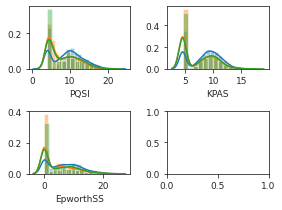

In [146]:
fig, ax = plt.subplots(2, 2, figsize=(4, 3))
# Pittsburgh Slp Questionnaire 
for i in range(1, 4):
    sns.distplot(raw_md['PQSI_%s' % i], ax=ax[0, 0], label='%s' % i)
    ax[0, 0].set_xlabel('PQSI')
    ax[0, 0].set_ylabel('')
# ax.legend()
# Kaiser-Permanente activity
for i in range(1, 4):
    sns.distplot(raw_md['KPAS_%s' % i], ax=ax[0, 1], label='%s' % i)
    ax[0, 1].set_xlabel('KPAS')
    ax[0, 1].set_ylabel('')

# epworth
for i in range(1, 4):
    sns.distplot(raw_md['EpworthSS_%s' % i], ax=ax[1, 0], label='%s' % i)
    ax[1, 0].set_xlabel('EpworthSS')
    ax[1, 0].set_ylabel('')
    
fig.tight_layout()




## Edinburgh depression

In [147]:
## Edinburgh
for i in range(1, 4):
    raw_md['Edinburgh_%s' % i] = (
        raw_md['edinb1_%strim' % i].fillna(value=1) - 1 + 
        raw_md['edinb2_%strim' % i].fillna(value=1) - 1 + 
        raw_md['edinb3_%strim' % i].fillna(value=1) - 1 + 
        raw_md['edinb4_%strim' % i].fillna(value=1) - 1 + 
        raw_md['edinb5_%strim' % i].fillna(value=1) - 1 + 
        raw_md['edinb6_%strim' % i].fillna(value=1) - 1 + 
        raw_md['edinb7_%strim' % i].fillna(value=1) - 1 + 
        raw_md['edinb8_%strim' % i].fillna(value=1) - 1 + 
        raw_md['edinb9_%strim' % i].fillna(value=1) - 1 + 
        raw_md['edinb10_%strim' % i].fillna(value=1) - 1
    )

In [152]:
visit_cmap = ['#5D5C61', '#7395AE', '#AC514F']

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figur

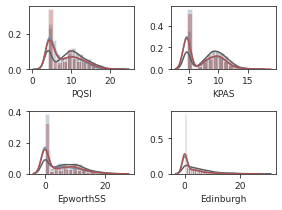

In [154]:
fig, ax = plt.subplots(2, 2, figsize=(4, 3))
# Pittsburgh Slp Questionnaire 
for i in range(1, 4):
    sns.distplot(raw_md['PQSI_%s' % i], ax=ax[0, 0], label='%s' % i,
                 color=visit_cmap[i-1])
    ax[0, 0].set_xlabel('PQSI')
    ax[0, 0].set_ylabel('')
# ax.legend()

# Kaiser-Permanente activity
for i in range(1, 4):
    sns.distplot(raw_md['KPAS_%s' % i], ax=ax[0, 1], label='%s' % i,
                 color=visit_cmap[i-1])
    ax[0, 1].set_xlabel('KPAS')
    ax[0, 1].set_ylabel('')

# epworth
for i in range(1, 4):
    sns.distplot(raw_md['EpworthSS_%s' % i], ax=ax[1, 0], label='%s' % i,
                 color=visit_cmap[i-1])
    ax[1, 0].set_xlabel('EpworthSS')
    ax[1, 0].set_ylabel('')
    
# edinburgh
for i in range(1, 4):
    sns.distplot(raw_md['Edinburgh_%s' % i], ax=ax[1, 1], label='%s' % i,
                 color=visit_cmap[i-1])
    ax[1, 1].set_xlabel('Edinburgh')
    ax[1, 1].set_ylabel('')
fig.tight_layout()


fig.savefig(os.path.join(pfp, 'distplot_calced_metrics_md.pdf'), bbox_inches='tight')

In [257]:
def compare_v3tov1(raw_metadata, metadata_prime, plot=True, var=['PQSI', 'KPAS', 'EpworthSS', 'Edinburgh'], save_magic=None, 
                   cmap={'V3': '#AC514F', 'V1': '#5D5C61'}):
    from scipy.stats import mannwhitneyu
    res = {v:None for v in var}
    for v in var:
        a = raw_metadata['%s_3' % v].to_numpy()
        b = raw_metadata['%s_1' % v].to_numpy()
        if any(b==0):
            print('+1 offset for {}'.format(v))
        mean_diff = np.mean((a - b)/b) if not any(b==0) else np.mean(((a+1) - (b+1))/(b+1))# pct change, adj for linear scale
        _, p = mannwhitneyu(a, b)
        res[v] = (mean_diff, p)
        all_measurements = [metadata_prime[v].quantile(0.5), metadata_prime[v].quantile(0.25), metadata_prime[v].quantile(0.75)]
        v3 = [np.median(a), np.quantile(a, 0.25), np.quantile(a, 0.75)]
        v1 = [np.median(b), np.quantile(b, 0.25), np.quantile(b, 0.75)]
        print('{}:'.format(v))
        print('  all: {:.2f} ({:.2f} - {:.2f})\tv3: {:.2f} ({:.2f} - {:.2f})\t v1: {:.2f} ({:.2f} - {:.2f})'.format(
            *all_measurements, *v3, *v1))
        
        if plot:
            fig, ax = plt.subplots(1, 2, figsize=(3.5, 2), gridspec_kw={'width_ratios': [3, 1]})
            ax[0].set_title(v)
            sns.distplot(metadata_prime[v], ax=ax[0], color='#FBC740')
            ax[0].set_xlabel('')
            ax[0].axes.get_yaxis().set_visible(False)
            dt = pd.DataFrame({'Percent change (%)': a, 'Visit': ['V3']*len(a)}).append(
                pd.DataFrame({'Percent change (%)': b, 'Visit': ['V1']*len(b)})
            )
            sns.boxplot(x="Visit", y="Percent change (%)", data=dt,
                        width=.6, palette=cmap, ax=ax[1])
            sns.stripplot(x="Visit", y="Percent change (%)", data=dt,
                          size=1, color=".3", linewidth=0, ax=ax[1], rasterized=True)
            ax[1].set_xlabel('')
            ax[1].set_ylabel('')
            ax[1].set_ylim([-1, 30])
            ax[1].set_yticks([0, 10, 20, 30])
            ax[1].set_yticklabels([0, '', '', 30])
            fig.tight_layout()
            
            if save_magic is not None:
                fig.savefig(save_magic + '_%s.pdf' % v, bbox_inches='tight', dpi=600)
    return res
        
        

PQSI:
  all: 10.00 (7.00 - 12.00)	v3: 7.00 (4.00 - 11.00)	 v1: 10.00 (6.00 - 12.00)


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


KPAS:
  all: 9.29 (7.82 - 10.50)	v3: 7.34 (4.57 - 9.74)	 v1: 8.95 (6.17 - 10.46)


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


+1 offset for EpworthSS
EpworthSS:
  all: 7.00 (3.00 - 11.00)	v3: 2.00 (0.00 - 9.00)	 v1: 6.00 (0.00 - 11.00)


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


+1 offset for Edinburgh
Edinburgh:
  all: 3.00 (0.00 - 6.00)	v3: 0.00 (0.00 - 4.00)	 v1: 4.00 (1.00 - 7.00)


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


{'PQSI': (-0.08052356611096274, 1.0733196732049082e-17),
 'KPAS': (-0.10039751980785562, 3.742214960640351e-31),
 'EpworthSS': (0.07837297732792424, 3.700091517307804e-28),
 'Edinburgh': (-0.12697778396235004, 1.5629424079869383e-86)}

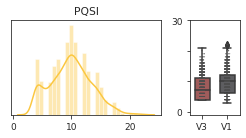

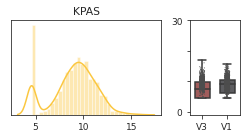

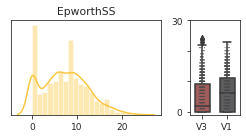

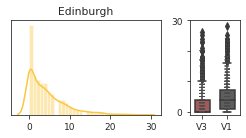

In [258]:
compare_v3tov1(raw_md, mdprime, save_magic=os.path.join(pfp, 'full_v3vv1_'))

In [260]:
mdprime.loc[mdprime['visit_num'] == 3, 'GA'].quantile([0.25, 0.5, 0.75])

0.25    31.0
0.50    33.0
0.75    34.0
Name: GA, dtype: float64

In [261]:
mdprime.loc[mdprime['visit_num'] == 1, 'GA'].quantile([0.25, 0.5, 0.75])

0.25     8.0
0.50    11.0
0.75    14.0
Name: GA, dtype: float64